core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.6.1]
INFO:fastf1.fastf1.core:Loading data for Azerbaijan Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core   

Filtered laps: 35 out of 37


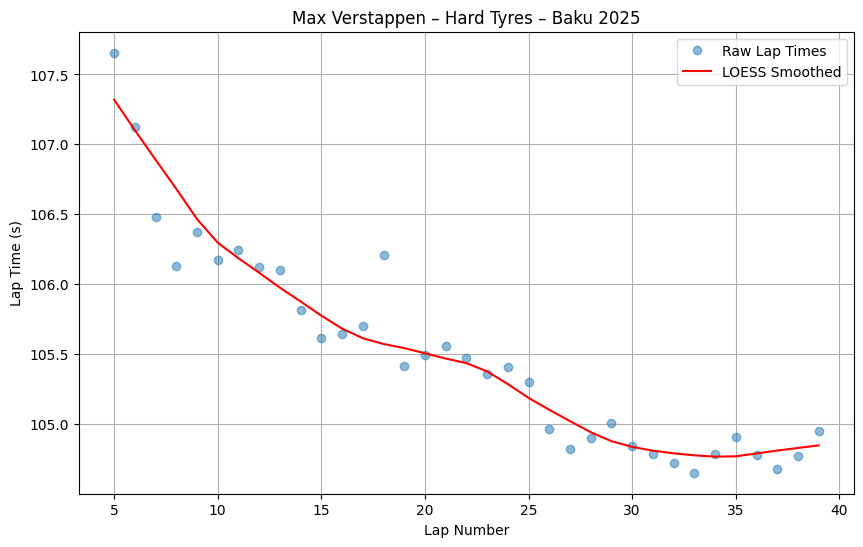

In [19]:
import fastf1
from fastf1 import plotting
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess
import os

# Enable Cache

if not os.path.exists('cache'):
  os.makedirs('cache')
fastf1.Cache.enable_cache('cache')

session = fastf1.get_session(2025, 'Azerbaijan Grand Prix', 'R')
session.load()

laps = session.laps

# Function to convert timedelta to seconds

def to_secs(td):
    return td.total_seconds() if pd.notnull(td) else np.nan

laps['LapTime_s'] = laps['LapTime'].apply(to_secs)


# Filter laps for Max Verstappen on HARD tyres

max_laps = laps[(laps['Driver'] == 'VER') &
                (laps['Compound'] == 'HARD') &
                (laps['LapTime'].notna())].copy()


# Filter for accurate laps only and remove pit laps

laps_filtered = max_laps[(max_laps['IsAccurate']) &
                         (max_laps['PitInTime'].isna()) &
                         (max_laps['PitOutTime'].isna())]


# Filter by lap time: within ±5 seconds of median pace

median_pace = laps_filtered['LapTime_s'].median()  # median pace of the stint
laps_filtered = laps_filtered[(laps_filtered['LapTime_s'] >= median_pace - 5) &
                              (laps_filtered['LapTime_s'] <= median_pace + 5)]

print(f"Filtered laps: {len(laps_filtered)} out of {len(max_laps)}")

# Prepare data for LOESS

X = laps_filtered['LapNumber']
y = laps_filtered['LapTime_s']


# Apply LOESS smoothing

smoothed = lowess(y, X, frac=0.3)  # frac controls smoothness


# Plot

plt.figure(figsize=(10,6))
plt.plot(X, y, 'o', alpha=0.5, label='Raw Lap Times')
plt.plot(smoothed[:,0], smoothed[:,1], '-', color='red', label='LOESS Smoothed')
plt.xlabel("Lap Number")
plt.ylabel("Lap Time (s)")
plt.title("Max Verstappen – Hard Tyres – Baku 2025")
plt.legend()
plt.grid(True)
plt.show()